**Groupe : Émile Pierret & David Soto**

Le code est organisé en suivant le plan de l'énoncé, excepté le fait que l'expérience avec ajout de bruit est mise directement après l'expérience sens bruit. A la fin de chaque sous-partie, il y a une section 'Bilan de nos expérimentations' qui contient des commentaires sur nos simulations.

# Reverse-time and Kirchhoff migration

## Importation de packages

In [2]:
import numpy as np
from scipy.special import hankel1,jv,yn
import pylab as plt
from tqdm.notebook import tqdm_notebook
from scipy.integrate import quad
i = complex(0.,1.)

## Fonctions transversales

### Fonction de Green en 2-D

In [3]:
def G0(w,x,y) :
    """ 
    INPUTS :
        - w   : pulsation
        - x,y : vecteurs 2-D
    OUTPUT : 
        - G0(w,x,y) """
    return i/4*hankel1(0,w*np.linalg.norm(x-y))

Ci-dessous, une fonction permettant de définir le vecteur $(\widehat{G}_0(\omega,\textbf{x}_r,\textbf{y}))_{r=1}^N$ ou sa version normalisée pour un ensemble de vecteur $\left[\textbf{x}_r\right]_{r=1}^N$ donné.

In [4]:
def g(w,x,y,normed = False) :
  """ 
  INPUTS :
      - w      : pulsation
      - x,y    : vecteurs 2-D
      - normed : booléen qui indique si l'output doit être normé ou non
  OUTPUT :
      - (G0(w,xr,y))_r
  """
  N = len(x)
  g = np.array([[G0(w,x[r,:],y)] for r in range(N)])
  if normed :
    return g/np.linalg.norm(g)
  else :
    return g

## Fonctions d'imagerie

### Fonction d'imagerie RT

La fonction ci-dessus trace la fonction d'imagerie RT où $D(\omega)$ est le tableau des données
$$I_\text{RT}(\textbf{z})  = \sum_\omega \overline{g(\omega,\textbf{z})}^T D(\omega) \overline{g(\omega,\textbf{z})}$$

In [5]:
def I_RT(freqs,D,xtrans,y) :
  """
  INPUTS :
     - freqs : ensemble des pulsations des données
     - D      : Données
     - xtrans : Positions des transducteurs
     - y      : vecteur
  OUTPUT :
     - Fonction d'imagerie RT en y
  """
  G_ = np.array([np.conjugate(g(w,xtrans,y)) for w in freqs])
  return np.sum(np.array([ G_[l].T.dot(D[l,:,:]).dot(G_[l])[0,0] for l in range(len(G_))]))

### Fonction d'imagerie KM

La fonction ci-dessus trace la fonction d'imagerie KM où $D(\omega)$ est le tableau des données
$$I_\text{KM}(\textbf{z})  = \sum_\omega \overline{k(\omega,\textbf{z})}^T D(\omega) \overline{k(\omega,\textbf{z})}$$

où $k(\omega,\textbf{z}) = \left[\exp\left( i \omega \|\textbf{x}_r - \textbf{z}\|\right)\right]_{r=1}^N$

In [6]:
def k_KM(w,xtrans,z) :
  """
  INPUTS :
     - w : pulsation
     - xtrans : Positions des transducteurs
     - z      : vecteur
  OUTPUT :
     - k(w,z)
  """
  N = len(xtrans)
  return np.array([[np.exp(i*w*np.linalg.norm(z-xtrans[r,:]))] for r in range(N)])

In [7]:
def I_KM(freqs,D,xtrans,y) :
  """
  INPUTS :
     - freqs : ensemble des pulsations des données
     - D      : Données
     - xtrans : Positions des transducteurs
     - z      : vecteur
  OUTPUT :
     - Fonction d'imagerie KM en z
  """
  K_ =  [np.conjugate(k_KM(w,xtrans,y)) for w in freqs]
  return np.sum(np.array([ K_[l].T.dot(D[l,:,:]).dot(K_[l])[0,0] for l in range(len(K_))]))

### Fonction d'imagerie MUSIC

La fonction ci-dessus trace la fonction d'imagerie MUSIC où $U$ est le tableau des données
$$I_\text{MUSIC}(\textbf{x}) = |\langle\widehat{g}(\omega,\textbf{x}),\textbf{v}_1 \rangle|^2$$

où $v_1$ est le premier vecteur singulier de $U$

In [8]:
def I_MUSIC(w,v1,xtrans,x) :
  """
  INPUTS :
     - w      : pulsation
     - v1     : premier vecteur singulier des données 
     - xtrans : Positions des transducteurs
     - x      : vecteur
  OUTPUT :
     - Fonction d'imagerie MUSIC en x
  """
  g_x = g(w,xtrans,x)
  return np.abs(np.vdot(g_x,v1))**2

## Fonctions de calul sur une maille

La fonction ci-dessous permet de calculer sur des mailles données en argument.

In [9]:
def calcul_im(x,y,U,freqs,xtrans,RT = False, KM = False, MUSIC = False) :
  """
  INPUTS :
     - x,y    : maille sur laquelle la fonction doit être calculée
     - U      : tableau des données
     - freqs  : tableau des fréquences
     - xtrans : Positions des transducteurs
     - RT     : Booléen qui indique si RT doit être calculé
  """
  #Création de la maille
  X,Y = np.meshgrid(x,y)
  n_x = len(x)
  n_y = len(y)
  output = []
  #Calcul RT
  if RT :
    Z_RT = np.zeros((n_y,n_x))
    for k in tqdm_notebook(range(n_y),desc='Calculating RT imaging') :
        for l in range(n_x) :
          y_ = np.array([x[l],y[k]])
          if not(y_ in xtrans) :
            Z_RT[k,l] = np.real(I_RT(freqs,U,xtrans,y_))
    output.append(Z_RT)
  #Calcul KM
  if KM :
    Z_KM = np.zeros((n_y,n_x))
    for k in tqdm_notebook(range(n_y),desc='Calculating KM imaging') :
        for l in range(n_x) :
            y_ = np.array([x[l],y[k]])
            Z_KM[k,l] = np.abs(I_KM(freqs,U,xtrans,y_))
    output.append(Z_KM)
  #Calcul MUSIC
  if MUSIC :
    #Calcul du premier vecteur singulier
    u,_,_ = np.linalg.svd(U[0,:,:])
    v1 = u[:,0]

    Z_MUSIC = np.zeros((n_y,n_x))

    for k in tqdm_notebook(range(n_y),desc='Calculating MUSIC imaging') :
        for l in range(n_x) :
            y_ = np.array([x[l],y[k]])
            if not(y_ in xtrans) :
              Z_MUSIC[k,l] =I_MUSIC(freqs[0],v1,xtrans,y_)
    output.append(Z_MUSIC)
  return output
   

# 2) Time-harmonic localization - full aperture

## Paramètres et génération de la position des points

(-110.0, 110.0, -110.0, 110.0)

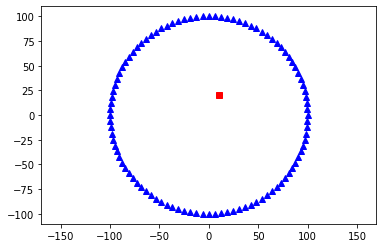

In [10]:
w = 2*np.pi
freqs = np.array([w])
R0 = 100 # radius
N = 100
xref = np.array([10,20])
xtrans = np.zeros((N,2))
for k in range(N) :
    xtrans[k,0] =R0*np.cos(2*np.pi*k/N)
    xtrans[k,1] = R0*np.sin(2*np.pi*k/N)

plt.plot(xref[0],xref[1],'rs')
for k in range(N) :
    plt.plot(xtrans[k,0],xtrans[k,1],'b^')
plt.axis('equal')

## Génération du data set

In [11]:
U = np.outer(g(w,xtrans,xref),g(w,xtrans,xref))

In [12]:
#grille de calcul de les fonctions d'imagerie
n = 201

x = np.linspace(-100,100,n)
y = np.linspace(-100,100,n)

[X,Y] = np.meshgrid(x,y)

## Présentation des solutions

In [13]:
Z_RT, Z_KM, Z_MUSIC = calcul_im(x,y,np.array([U]),freqs,xtrans,RT = True, KM = True, MUSIC = True)

Calculating RT imaging:   0%|          | 0/201 [00:00<?, ?it/s]

Calculating KM imaging:   0%|          | 0/201 [00:00<?, ?it/s]

Calculating MUSIC imaging:   0%|          | 0/201 [00:00<?, ?it/s]

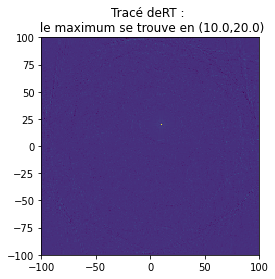

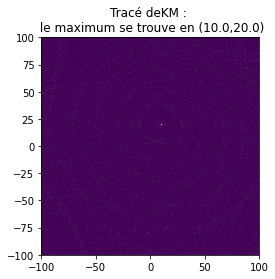

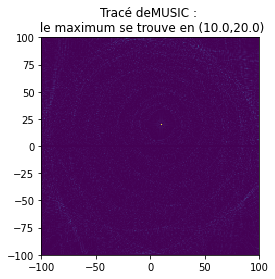

In [14]:
légende = ["RT","KM","MUSIC"]
k=0
for Z in [Z_RT, Z_KM,Z_MUSIC] :
#Tracé de RT______________________________________________________________________________
  #Calcul du maximum
  (k_star,l_star) = np.unravel_index(np.argmax(Z, axis=None), Z.shape)
  #Tracé
  plt.figure(k+1)
  plt.clf()
  plt.title('Tracé de' + légende[k] + ' : \n le maximum se trouve en (' + str(x[l_star]) + ',' + str(y[k_star])+')')
  plt.pcolor(X,Y,Z)
  plt.axis('scaled')
  k+=1

## Theoretical focal spot

Nous proposons ci-dessous le calcul théorique du focal spot :

\begin{align*}
    I_\text{RT}(x) 
    & = \sum_{r,s=1}^N \overline{\widehat{G}_0 (\omega, \textbf{x}_s,\textbf{x}) \widehat{G}_0 (\omega, \textbf{x}_r,\textbf{x})} \widehat{G}_0(\omega,\textbf{x}_r,\textbf{x}_\text{ref}) \widehat{G}_0(\omega,\textbf{x}_s,\textbf{x}_\text{ref}) \\
    & \approx \left(\int_{\partial B(0,R_0)} \overline{\widehat{G}_0 (\omega, \textbf{x}_s,\textbf{x})}\widehat{G}_0(\omega,\textbf{x}_r,\textbf{x}_\text{ref})d\textbf{z}\right)^2 \\
    & \approx \left(\text{Im}(\widehat{G}_0 (\omega, \textbf{x}_\text{ref},\textbf{x}))\right)^2  \text{ par identité de Helmholtz-Kirchhoff} \\
    & = \frac{1}{16}J_0(\omega|x-x_\text{ref}|)^2
\end{align*}

In [15]:
#Calcul du point focal théorique
Z_focal = np.zeros((n,n))

for k in tqdm_notebook(range(n),desc='Calculating theoretical focal spot') :
    for l in range(n) :
        Z_focal[k,l] = jv(0,w*np.linalg.norm(np.array([x[l],y[k]])-xref))**2

Calculating theoretical focal spot:   0%|          | 0/201 [00:00<?, ?it/s]

(-100.0, 100.0, -100.0, 100.0)

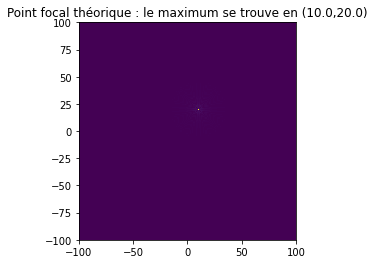

In [16]:
#Calcul du maximum
(k_star,l_star) = np.unravel_index(np.argmax(Z_focal, axis=None), Z_focal.shape)

#Tracé
plt.title('Point focal théorique : le maximum se trouve en (' + str(x[l_star]) + ',' + str(y[k_star])+')' )
plt.pcolor(X,Y,Z_focal)
plt.axis('scaled')

## Bilan de nos expérimentations

**A propos de RT :** Nous avons recontré quelques problèmes numériques lors de l'implémentation de **RT**. Lorsqu'on observe le module fonction de Hankel, on observe qu'elle explose en $0$. 

Or, au niveau des transducteurs, cette fonction est considérée en zéro ce qui créait des Nan.

Pour régler ce problème, nous avons retiré les points où se trouvent les transducteurs.

**A propos de KM :**
La fonction d'imagerie **KM** est plus stable numériquement que les fonctions RT et MUSIC.

**A propos de MUSIC :** **MUSIC** présente le même défaut d'instabilité que **RT**. La fonction d'imagerie **MUSIC** est plus rapide que **RT** et **KM**.

**A propos du changement de position du réflecteur :** il n'y a aucune difficulté au fait de bouger le réflecteur, nous avons par exemple expérimenter les positons $(10,20), (-50,-50), (-100,-75), (-100,0)$

# Experiment 2) with noise

## Paramètres et génération de la position des points

(-110.0, 110.0, -110.0, 110.0)

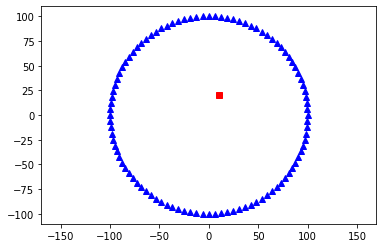

In [17]:
w = 2*np.pi
freqs = np.array([w])
R0 = 100 # radius
N = 100
xref = np.array([10,20])
xtrans = np.zeros((N,2))
for k in range(N) :
    xtrans[k,0] =R0*np.cos(2*np.pi*k/N)
    xtrans[k,1] = R0*np.sin(2*np.pi*k/N)

plt.plot(xref[0],xref[1],'rs')
for k in range(N) :
    plt.plot(xtrans[k,0],xtrans[k,1],'b^')
plt.axis('equal')

## Génération du data set

In [18]:
#Génération du bruit
sigma = .03
alpha = w**2*np.linalg.norm(g(w,xtrans,xref))
W1 = sigma/np.sqrt(2)*np.random.randn(N,N)
W2 = sigma/np.sqrt(2)*np.random.randn(N,N)

In [19]:
U = w**2*np.outer(g(w,xtrans,xref),g(w,xtrans,xref)) +W1+i*W2

In [20]:
#grille de calcul de les fonctions d'imagerie!
n = 201

x = np.linspace(-100,100,n)
y = np.linspace(-100,100,n)

X,Y = np.meshgrid(x,y)

## Calcul SNR

$$\text{SNR}_\text{image} = \frac{\alpha}{\sigma} = \frac{1}{\sigma} \omega^2 |g(\textbf{x}_\text{ref})|^2$$

On peut détecter le réflecteur si $\text{SNR}_\text{image} >1$

In [21]:
print('ICI SNR = ' + str(alpha/sigma))

ICI SNR = 105.39115511341083


## Présentation des solutions

In [22]:
Z_RT, Z_KM, Z_MUSIC = calcul_im(x,y,np.array([U]),freqs,xtrans,RT = True, KM = True, MUSIC = True)

Calculating RT imaging:   0%|          | 0/201 [00:00<?, ?it/s]

Calculating KM imaging:   0%|          | 0/201 [00:00<?, ?it/s]

Calculating MUSIC imaging:   0%|          | 0/201 [00:00<?, ?it/s]

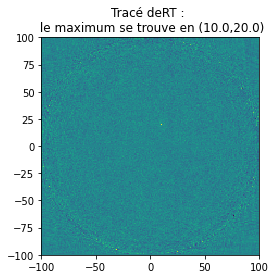

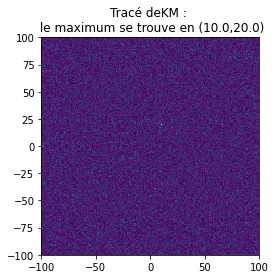

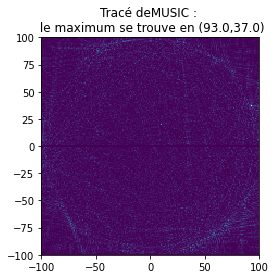

In [23]:
légende = ["RT","KM","MUSIC"]
k=0
for Z in [Z_RT, Z_KM,Z_MUSIC] :
#Tracé de RT______________________________________________________________________________
  #Calcul du maximum
  (k_star,l_star) = np.unravel_index(np.argmax(Z, axis=None), Z.shape)
  #Tracé
  plt.figure(k+1)
  plt.clf()
  plt.title('Tracé de' + légende[k] + ' : \n le maximum se trouve en (' + str(x[l_star]) + ',' + str(y[k_star])+')')
  plt.pcolor(X,Y,Z)
  plt.axis('scaled')
  k+=1

## Bilan de nos expérimentations 

La fonction **KM** est plus stable que la fonction **RT**. Par exemple, la fonction **RT** peut être mise en défaut avec la position du réflecteur en $(-100,-75)$ tandis que **KM** fonctionne dans ce cas.

La fonction **MUSIC** ne fonctionne pas en présence de bruit pour la raison évoquée ci-dessous.

La fonction d'imagerie MUSIC où $U$ est le tableau des données
$$I_\text{MUSIC}(\textbf{x}) = |\langle\widehat{g}(\omega,\textbf{x}),\textbf{v}_1 \rangle|^2$$

où $v_1$ est le premier vecteur singulier de $U$

Elle repose sur le fait que $U$ est de rang $1$. 

En effet, si $U = \widehat{g}(\omega,\textbf{x}_\text{ref})^T\widehat{g}(\omega,\textbf{x}_\text{ref})$

alors $v_1 = \frac{1}{\|\widehat{g}(\omega,\textbf{x}_\text{ref})\|}\widehat{g}(\omega,\textbf{x}_\text{ref})$

et donc la fonction d'imagerie est bien maximal en $\textbf{x}_\text{ref}$. 

Or, ici, comme le prouve la ligne de code suivante, la matrice $U$ n'est pas de rang $1$ : on affiche ses valeurs singulières et on observe que la première valeur ne surpasse pas les suivantes.

In [24]:
_,sig,_ = np.linalg.svd(U)
print(sig)

[0.5865696  0.56686319 0.55016836 0.54486218 0.53176902 0.52215152
 0.51099649 0.50237312 0.49962272 0.48770686 0.48247192 0.46996674
 0.46636371 0.46055956 0.45211734 0.44237825 0.43071732 0.42771815
 0.41981594 0.41250132 0.40914471 0.4026092  0.39667811 0.39421636
 0.38835401 0.38360283 0.37597453 0.36858613 0.35293197 0.35101057
 0.34480351 0.34171861 0.33376765 0.33187904 0.3207619  0.31949748
 0.3149956  0.31348738 0.30366027 0.30136887 0.29026017 0.28973409
 0.28141307 0.27100917 0.2671046  0.26153096 0.26057127 0.25554116
 0.25363671 0.24702987 0.23852392 0.23451058 0.22959492 0.22521832
 0.22325401 0.21494255 0.20974621 0.20463978 0.19981802 0.19452139
 0.18983919 0.18673454 0.17952814 0.1728066  0.16604041 0.16071982
 0.15731016 0.15119588 0.14794567 0.1452391  0.14104347 0.13117496
 0.12572805 0.12174587 0.11766287 0.11046277 0.10564874 0.09869986
 0.09684391 0.09022531 0.08756453 0.08445419 0.07958611 0.07433103
 0.07055182 0.06758815 0.0610593  0.0584592  0.05566254 0.0512

# 3) Time-harmonic localization - partial aperture

## Paramètres et génération de la position des points

(-28.005050505050505, 26.994949494949495, -5.0, 105.0)

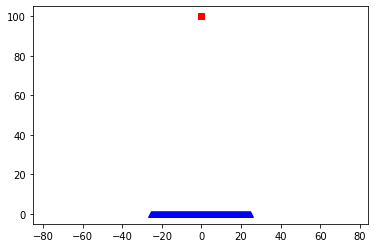

In [25]:
w = 2*np.pi
freqs = np.array([w])
R0 = 50
N = 100
xref = np.array([0,100])
xtrans = np.zeros((N,2))
for k in range(N) :
    xtrans[k,0] = -R0/2 + R0*(k-1)/(N-1)

plt.plot(xref[0],xref[1],'rs')
for k in range(N) :
    plt.plot(xtrans[k,0],xtrans[k,1],'b^')
plt.axis('equal')

## Génération du data set

In [28]:
U = np.outer(g(w,xtrans,xref),g(w,xtrans,xref))

In [29]:
#grille de calcul de toutes les futures fonctions
n_x = 161
n_y = 221
x = np.linspace(-40,40,n_x)
y = np.linspace(20,120,n_y)

X,Y = np.meshgrid(x,y)

## Présentation des solutions

Dans ce cadre la solution RT présente le défaut suivant : elle est symétrique par rapport à la ligne de transducteurs. Il faut donc connaître de quel côté se trouve le réflecteur. En ce qui concerne le défaut évoqué précédemment, une fois le côté connu, il suffit d'intégrer "la zone de sécurité" dans la zone de calcul de la fonction d'imagerie.

In [30]:
Z_RT, Z_KM, Z_MUSIC = calcul_im(x,y,np.array([U]),freqs,xtrans,RT = True, KM = True, MUSIC = True)

Calculating RT imaging:   0%|          | 0/221 [00:00<?, ?it/s]

Calculating KM imaging:   0%|          | 0/221 [00:00<?, ?it/s]

Calculating MUSIC imaging:   0%|          | 0/221 [00:00<?, ?it/s]

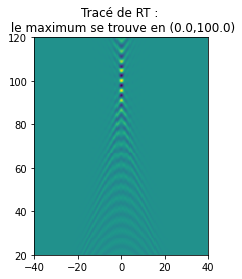

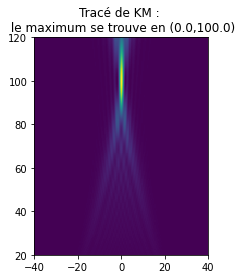

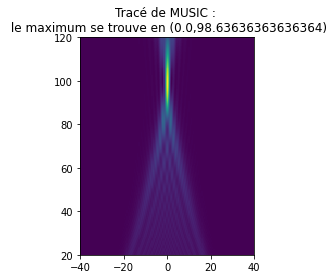

In [31]:
légende = ["RT","KM","MUSIC"]
k=0
for Z in [Z_RT, Z_KM,Z_MUSIC] :
#Tracé de RT______________________________________________________________________________
  #Calcul du maximum
  (k_star,l_star) = np.unravel_index(np.argmax(Z, axis=None), Z.shape)
  #Tracé
  plt.figure(k+1)
  plt.clf()
  plt.title('Tracé de ' + légende[k] + ' : \n le maximum se trouve en (' + str(x[l_star]) + ',' + str(y[k_star])+')')
  plt.pcolor(X,Y,Z)
  plt.axis('scaled')
  k+=1

## Focal spot along x-axis

<Figure size 432x288 with 0 Axes>

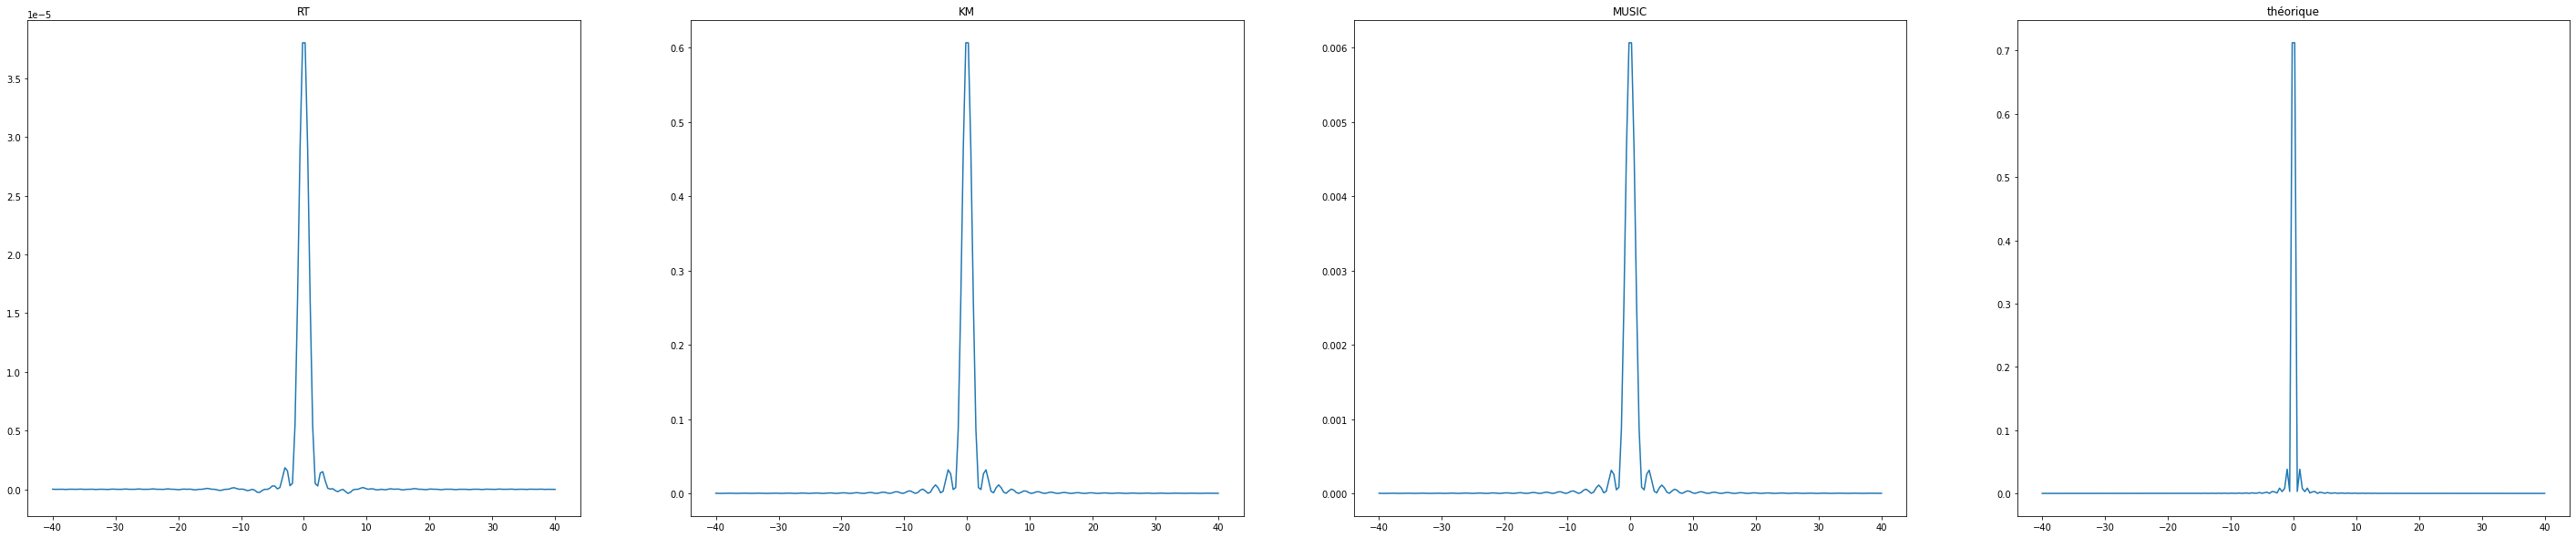

In [32]:
n = 200
x = np.linspace(-40,40,n)
u,_,_ = np.linalg.svd(U)
v1 = u[:,0]
#Calcul pour RT,KM,MUSIC
x_focal_RT = np.zeros(n)
x_focal_KM = np.zeros(n)
x_focal_MUSIC = np.zeros(n)
for k in range(n) :
      y_ = np.array([x[k],xref[1]])
      x_focal_RT[k] = np.real(I_RT(freqs,np.array([U]),xtrans,y_))
      x_focal_KM[k] = np.abs(I_KM(freqs,np.array([U]),xtrans,y_))
      x_focal_MUSIC[k] = I_MUSIC(w,v1,xtrans,y_)

#Tracés
plt.figure(1)
plt.clf()
plt.figure(figsize=(50,10))
plt.subplot(1,4,1)
plt.title('RT')
plt.plot(x,x_focal_RT)
plt.subplot(1,4,2)
plt.title('KM')
plt.plot(x,x_focal_KM)
plt.subplot(1,4,3)
plt.title('MUSIC')
plt.plot(x,x_focal_MUSIC)

#Tracé théorique
lamb = 2*np.pi/w
rc = lamb*np.linalg.norm(xref)/R0
plt.subplot(1,4,4)
plt.title('théorique')
plt.plot(x,np.sinc(np.pi*(x-xref[0])/rc)**2)

## Focal spot along z-axis

/usr/local/lib/python3.7/dist-packages/scipy/integrate/quadpack.py:453: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


<Figure size 432x288 with 0 Axes>

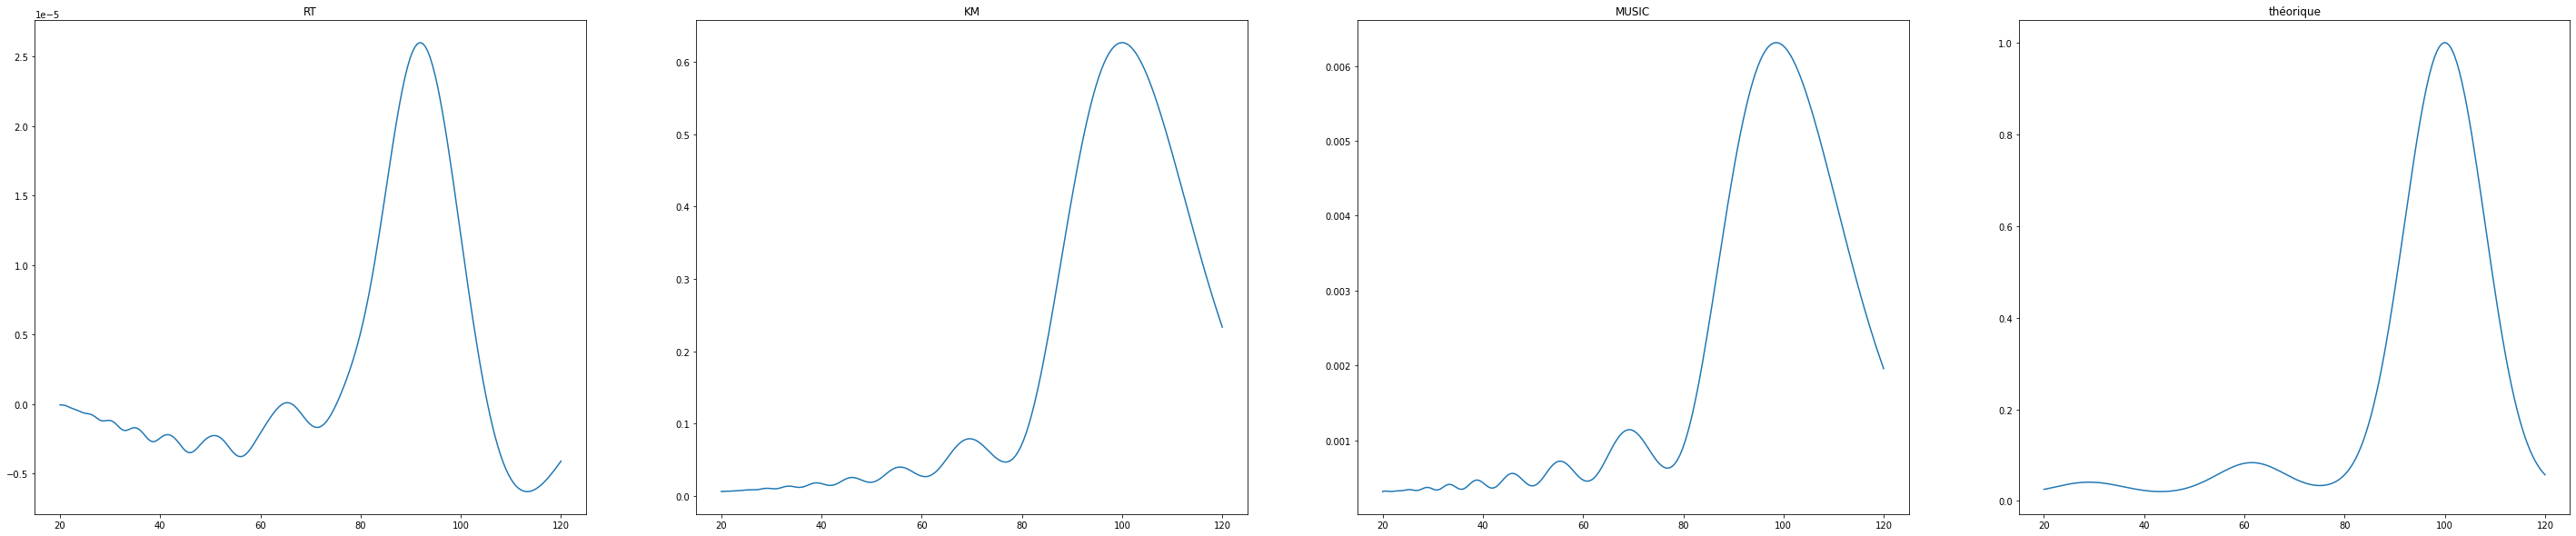

In [33]:
n = 200
z = np.linspace(20,120,n)
u,_,_ = np.linalg.svd(U)
v1 = u[:,0]
#Calcul pour RT,KM,MUSIC
z_focal_RT = np.zeros(n)
z_focal_KM = np.zeros(n)
z_focal_MUSIC = np.zeros(n)
for k in range(n) :
      y_ = np.array([xref[0],z[k]])
      z_focal_RT[k] = np.real(I_RT(freqs,np.array([U]),xtrans,y_))
      z_focal_KM[k] = np.abs(I_KM(freqs,np.array([U]),xtrans,y_))
      z_focal_MUSIC[k] = I_MUSIC(w,v1,xtrans,y_)

#Calcul théorique
lamb = 2*np.pi/w
rl = 2*lamb*np.linalg.norm(xref)**2/R0**2
z_focal = np.zeros(n)
for k in range(n) :
  f_z = lambda s : np.exp(-i*np.pi/2*s**2*np.abs(z[k]-xref[1])/rl)
  z_focal[k] = np.abs(quad(f_z,0.,1.))[0]**2

#Tracés
plt.figure(1)
plt.clf()
plt.figure(figsize=(50,10))
plt.subplot(1,4,1)
plt.title('RT')
plt.plot(z,z_focal_RT)
plt.subplot(1,4,2)
plt.title('KM')
plt.plot(z,z_focal_KM)
plt.subplot(1,4,3)
plt.title('MUSIC')
plt.plot(z,z_focal_MUSIC)
plt.subplot(1,4,4)
plt.title('théorique')
plt.plot(z,z_focal)

## Bilan de nos expérimentations 

Nous avons remarqué que la valeur de $R_0$ est cruciale. Par exemple, diminuer $R_0$ à $R_0 = 10$ fait que les fonctions d'imagerie **RT** et **MUSIC** ne permettent plus de situer le réflecteur. En revanche, **KM** continue à fonctionner correctement.

En revanche, en gardant $R_0 = 50$ et bougeant le réflecteur en $(-22,100)$ par exemple, on remarque que les fonctions d'imagerie continue à fournir un résultat satisfaisant.

Une nouvelle fois, **KM** est meilleure que **RT** qui est meilleur que **MUSIC** dans cette expérimentation.

# Experiment 3) with noise

## Paramètres et génération de la position des points

(-28.005050505050505, 26.994949494949495, -5.0, 105.0)

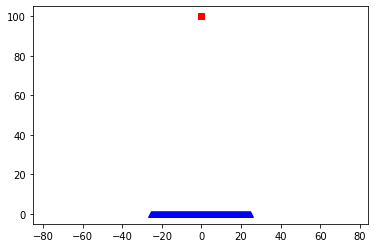

In [34]:
w = 2*np.pi
freqs = np.array([w])
R0 = 50
N = 100
xref = np.array([0,100])
xtrans = np.zeros((N,2))
for k in range(N) :
    xtrans[k,0] = -R0/2 + R0*(k-1)/(N-1)

plt.plot(xref[0],xref[1],'rs')
for k in range(N) :
    plt.plot(xtrans[k,0],xtrans[k,1],'b^')
plt.axis('equal')

## Génération du data set

In [35]:
#Génération du bruit
sigma = .01
alpha = w**2*np.linalg.norm(g(w,xtrans,xref))
W1 = sigma/np.sqrt(2)*np.random.randn(N,N)
W2 = sigma/np.sqrt(2)*np.random.randn(N,N)

In [36]:
U = w**2*np.outer(g(w,xtrans,xref),g(w,xtrans,xref)) +W1 + i*W2

In [37]:
#grille de calcul de toutes les futures fonctions
n_x = 161
n_y = 221
x = np.linspace(-40,40,n_x)
y = np.linspace(20,120,n_y)

X,Y = np.meshgrid(x,y)

## Calcul SNR

$$\text{SNR}_\text{image} = \frac{\alpha}{\sigma} = \frac{1}{\sigma} \omega^2 |g(\textbf{x}_\text{ref})|^2$$

On peut détecter le réflecteur si $\text{SNR}_\text{image} >1$

In [38]:
print('ICI SNR = ' + str(alpha/sigma))

ICI SNR = 312.53001416140495


## Présentation des solutions

In [39]:
Z_RT, Z_KM, Z_MUSIC = calcul_im(x,y,np.array([U]),freqs,xtrans,RT = True, KM = True, MUSIC = True)

Calculating RT imaging:   0%|          | 0/221 [00:00<?, ?it/s]

Calculating KM imaging:   0%|          | 0/221 [00:00<?, ?it/s]

Calculating MUSIC imaging:   0%|          | 0/221 [00:00<?, ?it/s]

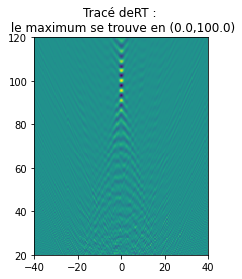

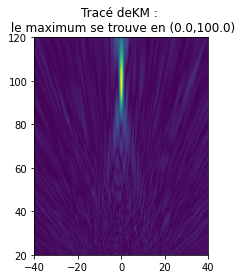

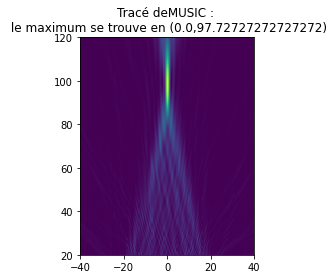

In [40]:
légende = ["RT","KM","MUSIC"]
k=0
for Z in [Z_RT, Z_KM,Z_MUSIC] :
#Tracé de RT______________________________________________________________________________
  #Calcul du maximum
  (k_star,l_star) = np.unravel_index(np.argmax(Z, axis=None), Z.shape)
  #Tracé
  plt.figure(k+1)
  plt.clf()
  plt.title('Tracé de' + légende[k] + ' : \n le maximum se trouve en (' + str(x[l_star]) + ',' + str(y[k_star])+')')
  plt.pcolor(X,Y,Z)
  plt.axis('scaled')
  k+=1

## Bilan de nos expérimentations 

On observe les mêmes résultats que dans la partie 2) avec bruit ie **KM** est meilleure que **RT** et **MUSIC** ne fonctionne pas en présence de bruit.

# 4) Time-dependent localization - partial aperture

## Paramètres et génération de la position des points

(-11.512820512820513, 10.487179487179485, -5.0, 105.0)

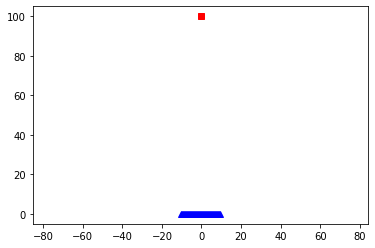

In [41]:
w0 = 2*np.pi
B = 0.05*w0
i = complex(0.,1.)
R0 = 20
N = 40
freqs = np.linspace(w0-B,w0+B,20)
xref = np.array([0,100])
xtrans = np.zeros((N,2))
for k in range(N) :
    xtrans[k,0] = -R0/2 + R0*(k-1)/(N-1)

plt.plot(xref[0],xref[1],'rs')
for k in range(N) :
    plt.plot(xtrans[k,0],xtrans[k,1],'b^')
plt.axis('equal')

## Génération du data set

In [42]:
D = np.zeros((len(freqs),N,N),dtype=complex)
for l in range(len(freqs)) :
  w = freqs[l]
  D[l,:,:] = np.outer(g(w,xtrans,xref),g(w,xtrans,xref))*(w0-B <= w <= w0+B)

In [43]:
#grille de calcul de toutes les futures fonctions
n_x = 161
n_y = 221
x = np.linspace(-40,40,n_x)
y = np.linspace(20,120,n_y)

X,Y = np.meshgrid(x,y)

## Présentation des solutions

In [44]:
Z_RT, Z_KM = calcul_im(x,y,D,freqs,xtrans,RT = True, KM = True)

Calculating RT imaging:   0%|          | 0/221 [00:00<?, ?it/s]

Calculating KM imaging:   0%|          | 0/221 [00:00<?, ?it/s]

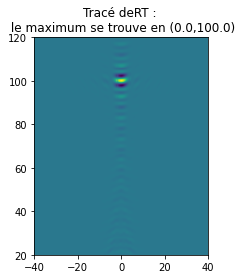

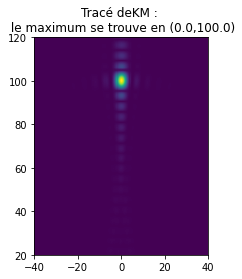

In [45]:
légende = ["RT","KM"]
k=0
for Z in [Z_RT, Z_KM] :
#Tracé de RT______________________________________________________________________________
  #Calcul du maximum
  (k_star,l_star) = np.unravel_index(np.argmax(Z, axis=None), Z.shape)
  #Tracé
  plt.figure(k+1)
  plt.clf()
  plt.title('Tracé de' + légende[k] + ' : \n le maximum se trouve en (' + str(x[l_star]) + ',' + str(y[k_star])+')')
  plt.pcolor(X,Y,Z)
  plt.axis('scaled')
  k+=1

## Focal spot along x-axis

<Figure size 432x288 with 0 Axes>

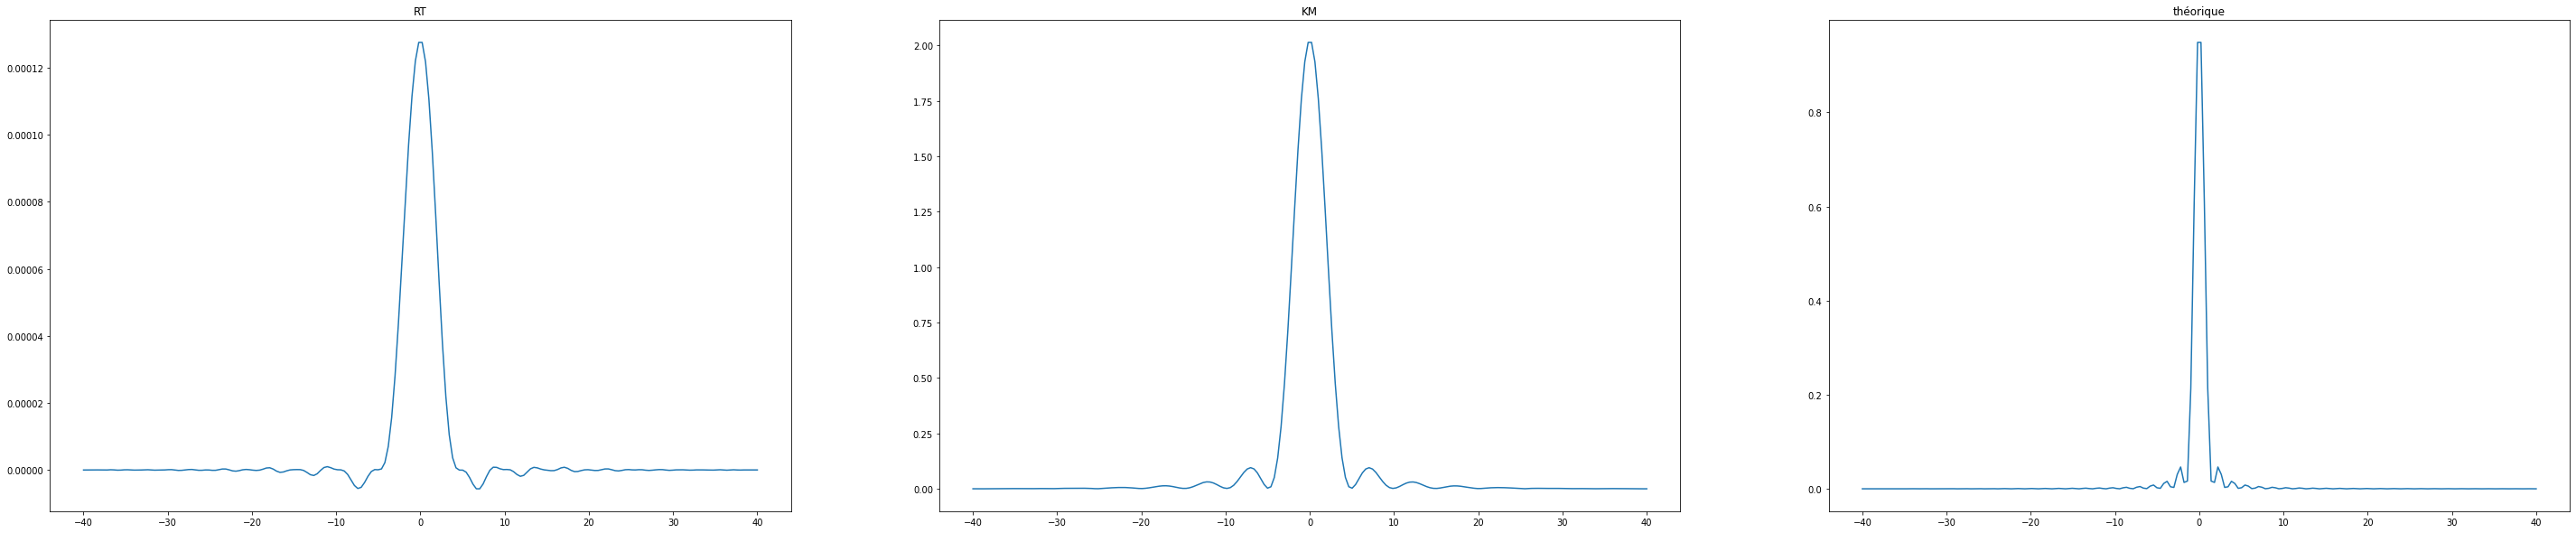

In [46]:
n = 200
x = np.linspace(-40,40,n)

#Calcul pour RT,KM
x_focal_RT = np.zeros(n)
for k in range(n) :
      y_ = np.array([x[k],xref[1]])
      x_focal_RT[k] = np.real(I_RT(freqs,D,xtrans,y_))
      x_focal_KM[k] = np.abs(I_KM(freqs,D,xtrans,y_))

#Tracés
plt.figure(1)
plt.clf()
plt.figure(figsize=(50,10))
plt.subplot(1,3,1)
plt.title('RT')
plt.plot(x,x_focal_RT)
plt.subplot(1,3,2)
plt.title('KM')
plt.plot(x,x_focal_KM)


#Tracé théorique
lamb0 = 2*np.pi/w0
rc = lamb0*np.linalg.norm(xref)/R0

plt.subplot(1,3,3)
plt.title('théorique')
plt.plot(x,np.sinc(np.pi*np.abs(x-xref[0])/rc)**2)

## Focal spot along z-axis

<Figure size 432x288 with 0 Axes>

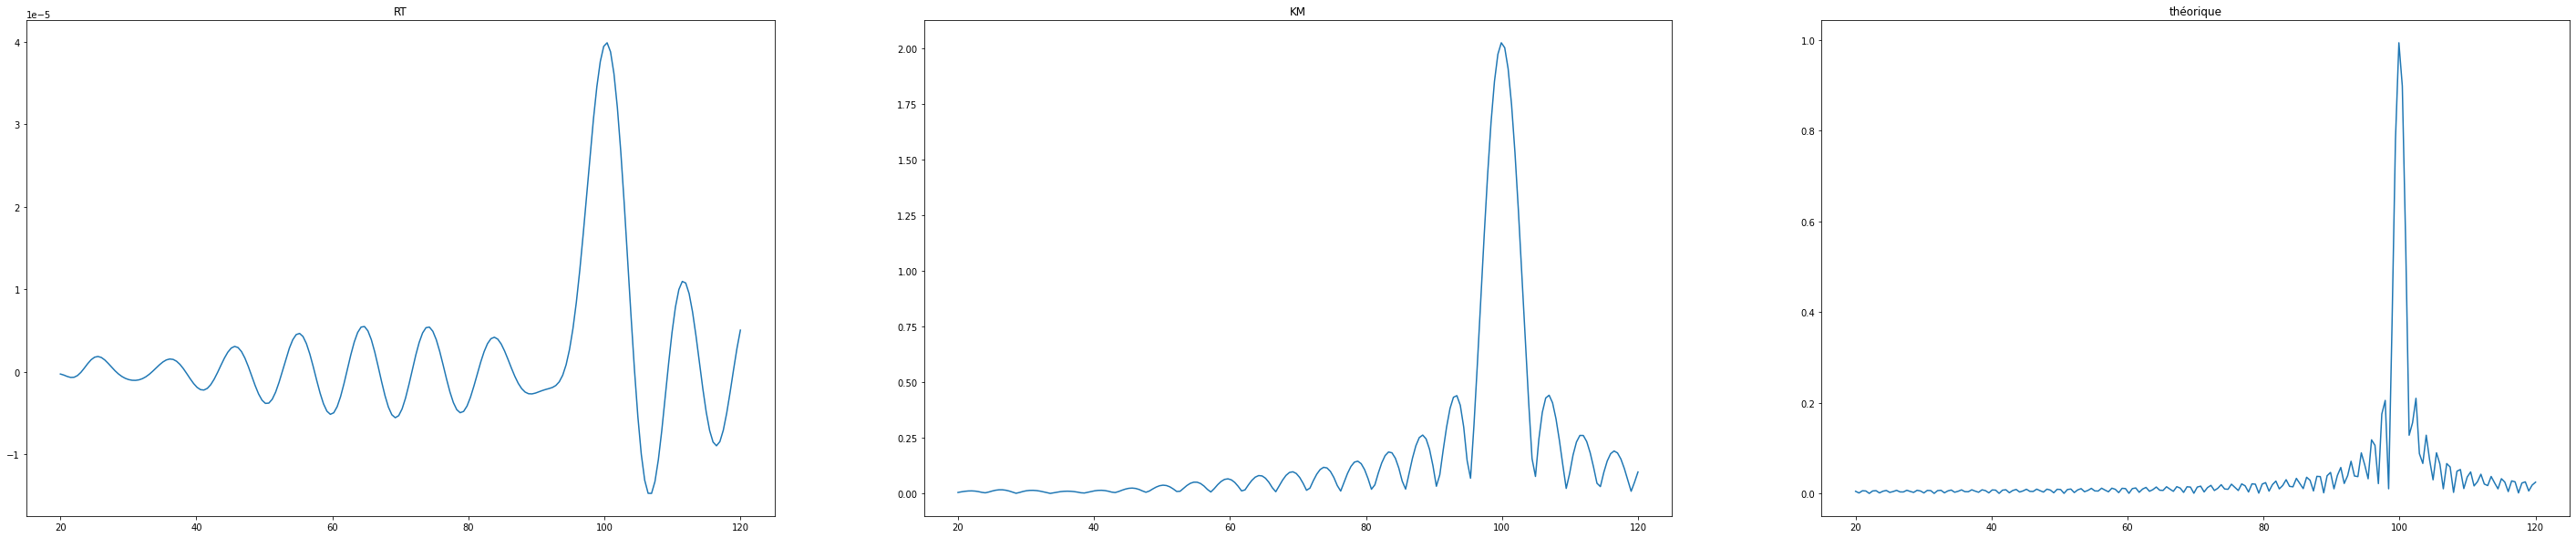

In [47]:
n = 200
z = np.linspace(20,120,n)

#Calcul pour RT
z_focal_RT = np.zeros(n)
z_focal_KM = np.zeros(n)
for k in range(n) :
      y_ = np.array([xref[0],z[k]])
      z_focal_RT[k] = np.real(I_RT(freqs,D,xtrans,y_))
      z_focal_KM[k] = np.abs(I_KM(freqs,D,xtrans,y_))

#Tracés
plt.figure(1)
plt.clf()
plt.figure(figsize=(50,10))
plt.subplot(1,3,1)
plt.title('RT')
plt.plot(z,z_focal_RT)
plt.subplot(1,3,2)
plt.title('KM')
plt.plot(z,z_focal_KM)
plt.subplot(1,3,3)
plt.title('théorique')
plt.plot(z,np.abs(np.sinc(2*B*np.abs(z-xref[1]))))

## Bilan de nos expérimentations 

Le fait d'avoir pris une fonction indicatrice dans le domaine des fréquences fait apparaître des ondulations dans les fonctions d'imagerie car alors un sinus cardinal apparaît.

Réduire $B$ ne provoque pas d'effet indésirable.

En revanche, prendre $B = 0.1$ fait apparaître un autre maximum. Cet artefact peut être supprimé en augmentant le nombre de fréquences considéré (à $30$) par exemple. En observant le focal spot le long de l'axe de $z$, on peut voir que **KM** accentue moins cet artefact que **RT**.

# Experiment 4) with noise

## Paramètres et génération de la position des points

(-11.512820512820513, 10.487179487179485, -5.0, 105.0)

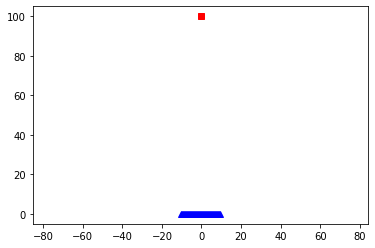

In [48]:
w0 = 2*np.pi
B = 0.05*w0
i = complex(0.,1.)
R0 = 20
N = 40
freqs = np.linspace(w0-B,w0+B,20)
xref = np.array([0,100])
xtrans = np.zeros((N,2))
for k in range(N) :
    xtrans[k,0] = -R0/2 + R0*(k-1)/(N-1)

plt.plot(xref[0],xref[1],'rs')
for k in range(N) :
    plt.plot(xtrans[k,0],xtrans[k,1],'b^')
plt.axis('equal')

## Génération du data set

In [49]:
#Paramètre du bruit
sigma = .001

In [50]:
D = np.zeros((len(freqs),N,N),dtype=complex)
for l in range(len(freqs)) :
  #Génération du bruit
  W1 = sigma/np.sqrt(2)*np.random.randn(N,N)
  W2 = sigma/np.sqrt(2)*np.random.randn(N,N)
  w = freqs[l]
  D[l,:,:] = np.outer(g(w,xtrans,xref),g(w,xtrans,xref))*(w0-B <= w <= w0+B) +W1+i*W2

In [51]:
#grille de calcul de toutes les futures fonctions
n_x = 161
n_y = 221
x = np.linspace(-40,40,n_x)
y = np.linspace(20,120,n_y)

X,Y = np.meshgrid(x,y)

## Présentation des solutions

In [52]:
Z_RT, Z_KM = calcul_im(x,y,D,freqs,xtrans,RT = True, KM = True)

Calculating RT imaging:   0%|          | 0/221 [00:00<?, ?it/s]

Calculating KM imaging:   0%|          | 0/221 [00:00<?, ?it/s]

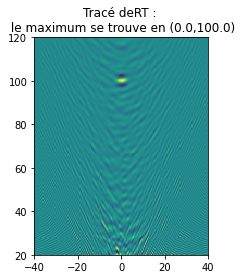

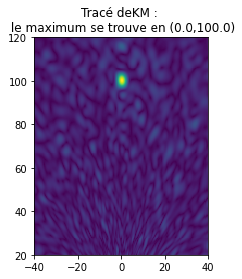

In [53]:
légende = ["RT","KM"]
k=0
for Z in [Z_RT, Z_KM] :
#Tracé de RT______________________________________________________________________________
  #Calcul du maximum
  (k_star,l_star) = np.unravel_index(np.argmax(Z, axis=None), Z.shape)
  #Tracé
  plt.figure(k+1)
  plt.clf()
  plt.title('Tracé de' + légende[k] + ' : \n le maximum se trouve en (' + str(x[l_star]) + ',' + str(y[k_star])+')')
  plt.pcolor(X,Y,Z)
  plt.axis('scaled')
  k+=1

## Bilan de nos expérimentations 

En présence de bruit, **KM** est plus robuste que **RT**

# Conclusions

La fonction **KM** est bien plus robuste que les fonctions **MUSIC** et **RT**. Elle est plus stable numériquement et continue de fonctionner malgré le changement des paramètres. **MUSIC** ne fonctionne pas en présence de bruit.